# Experience 7b: Laplacian Operator and Diffusion in 2D

The diffusion of taste is not the same thing as the improvement of taste.
William Hazlitt


## 2D Explicit formulation using operators

Let's look at how we can use the operators that we introduced in the past experience to write the 2D version in Python of the explicit diffusion algorithm. I will assume that NumPy and Matplotlib Pyplot are loaded and that $buildSparseOperatorXaxis$ and $buildSparseOperatorYaxis$ are defined as in the previous lecture on Operators. We first set the variables and create the arrays:

In [4]:
import numpy as np

nxp=10; nxc=nxp-1; xTot=1.0; 
nyp=10; nyc=nyp-1; yTot=1.0; 

dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0

steps=1000; totalTime=1.0; plotEverySteps = 100; 
deltaTime=totalTime/steps; diffusivity=5e-2; 
r = deltaTime*diffusivity/(dx*dy)

X=np.arange(nxp)*dx+xMin
Y=np.arange(nyp)*dy+yMin
T=np.outer(np.sin(2*np.pi*X),np.sin(2*np.pi*Y))

where the temperature is defined by a combination of sinusoidal waves. It is possible of course to use any other initial condition. 

To create the necessary operators, one pragmatic and simple way is to combine derivative operators. As we did for the Strain Rate calculation, here we have to build the derivative operator in x and y. This time however we need to apply both x and y operators twice. Since the first derivative has to be centered in the cell, it will have a smaller size, being $(nxp-1 \times nyp-1) \times (nxp-1 \times nyp-1)$. These operators are called here $cellDxOp$ and $cellDyOp$. 

The second derivative needs to be applied to a smaller set of points (only the cell centers) and will be therefore centered at the internal nodes of the domain. These operators are called here $cellDxOpSecond$ and $cellDyOpSecond$. Finally the four operators are combined to create the $Laplacian$ operator, which corresponds to $\partial^2/\partial x^2$ and $\partial^2/\partial y^2$:


In [5]:
import scipy.sparse as sparse

def buildSparseOperatorXaxis(nx,ny,k1,k2):
    nx1=nx-1
    firstDiag=np.ones(nx*ny,float)*k1
    secondDiag=np.ones(nx*ny,float)*k2
    offsets=np.array([0,ny])
    return ( sparse.dia_matrix(([firstDiag,secondDiag],offsets), shape=(nx1*ny,nx*ny)).tocsr() )           

def buildSparseOperatorYaxis(nx,ny,k1,k2):
    ny1=ny-1
    firstDiag=np.ones(ny,float)*k1
    secondDiag=np.ones(ny,float)*k2
    offsets=np.array([0,1])
    block = sparse.dia_matrix(([firstDiag,secondDiag],offsets), shape=(ny1,ny)).tocsr()
    return (sparse.kron(sparse.eye(nx),block))

# create operator for the first derivative
DxOp = buildSparseOperatorXaxis(nxp,nyc,-1.0/dx,1.0/dx) 
DyOp = buildSparseOperatorYaxis(nxc,nyp,-1.0/dy,1.0/dy) 
sideXOp =buildSparseOperatorYaxis(nxp,nyp, 0.5, 0.5) 
sideYOp = buildSparseOperatorXaxis(nxp,nyp, 0.5, 0.5)

cellDxOp = DxOp.dot(sideXOp) 
cellDyOp = DyOp.dot(sideYOp)

# create a smaller operator for the second derivative 
DxOpSecond = buildSparseOperatorXaxis(nxp-1,nyc-1,-1.0/dx,1.0/dx) 
DyOpSecond = buildSparseOperatorYaxis(nxc-1,nyp-1,-1.0/dy,1.0/dy) 
sideXOpSecond =buildSparseOperatorYaxis(nxp-1,nyp-1, 0.5, 0.5) 
sideYOpSecond = buildSparseOperatorXaxis(nxp-1,nyp-1, 0.5, 0.5)

cellDxOpSecond = DxOpSecond.dot(sideXOpSecond) 
cellDyOpSecond = DyOpSecond.dot(sideYOpSecond)

# apply operators together to create x and y second derivative
# The Laplacian operator is the sum of the second derivative in each direction
LaplacianOp = cellDxOpSecond.dot(cellDxOp) + cellDyOpSecond.dot(cellDyOp)

#print(LaplacianOp)

There is actually an even more elegant way to create a Laplacian operator. In fact, a Laplacian is also the inner product of two gradients. Traslated in operatorial terms, the more compact version of the same calculation is the following, which gives the same result:

In [6]:
# Functional approach to the calculation of the Laplacian
def sparseGradientOperator(nxp,nyp,dx,dy):
    DxOp = buildSparseOperatorXaxis(nxp,nyp-1,-1.0/dx,1.0/dx)
    DyOp = buildSparseOperatorYaxis(nxp-1,nyp,-1.0/dy,1.0/dy)
    sideXOp=buildSparseOperatorYaxis(nxp,nyp, 0.5, 0.5)
    sideYOp=buildSparseOperatorXaxis(nxp,nyp, 0.5, 0.5) 
    return(DxOp.dot(sideXOp),DyOp.dot(sideYOp)) 

def sparseLaplacianOperator(nxp,nyp,dx,dy):    
    (cellDxOp,cellDyOp)=sparseGradientOperator(nxp,nyp,dx,dy) 
    (cellDxOpSmall,cellDyOpSmall)=sparseGradientOperator(nxp-1,nyp-1,dx,dy)   
    return(cellDxOpSmall.dot(cellDxOp)+cellDyOpSmall.dot(cellDyOp))


## Exercise 1
Visualize the different operators that we have created until now. The sparse ones will have to turned into dense to be plotted (with imshow, for example). Try to understand visually how the two techniques bring the to same result. Also, check!, are the results really equal? 

Hint: it is much easier to understand what happens with a very small mesh, like 7x7.

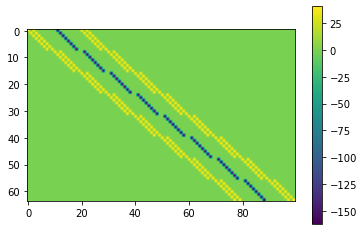

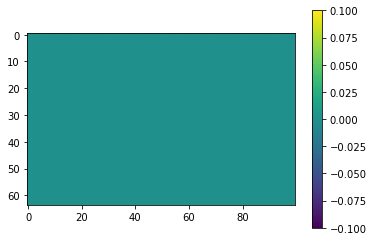

In [7]:
# here write your solution
import matplotlib.pyplot as plt
plt.imshow(LaplacianOp.todense());plt.colorbar()
plt.show()

test = sparseLaplacianOperator(nxp,nyp,dx,dy)
plt.imshow((test-LaplacianOp).todense());plt.colorbar()
plt.show()


Once the Laplacian operator is created, the explicit calculation of the temperature increment proceeds as earlier. Observe carefully how the matrix Temperature needs to be reshaped at each timestep. Is this going to slow down our calculations?

**A very important obsrvation is that this operator is not defined by a squared matrix. This means that it cannot be inverted**. If the mesh is fine, 100x100, one might not notice it, but it is extremely important. Only squared matrix can have a unique inverse. Rectangular matrices are very different, and can have either zero or ininite inverses.


step: 0


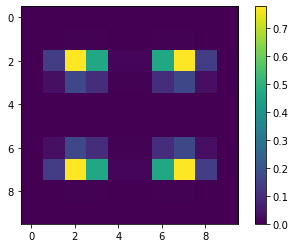

step: 100


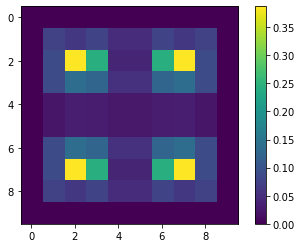

step: 200


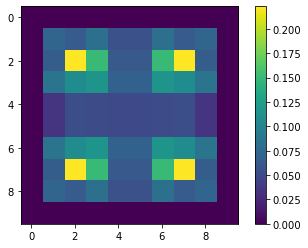

step: 300


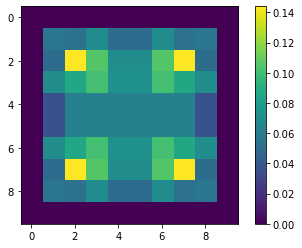

step: 400


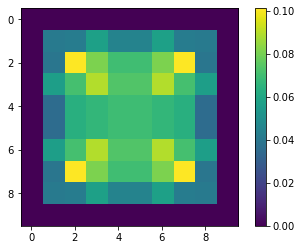

step: 500


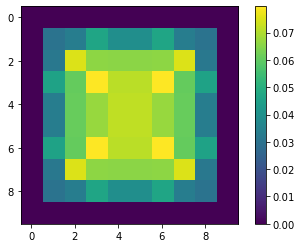

step: 600


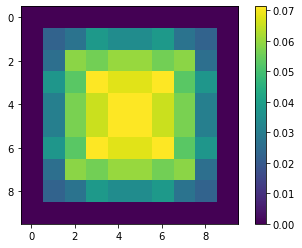

step: 700


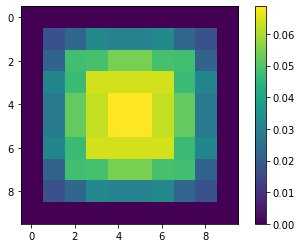

step: 800


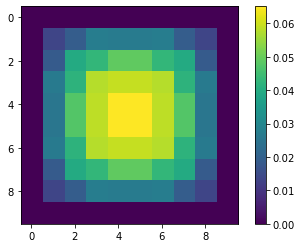

step: 900


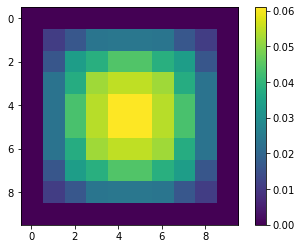

In [8]:
T=np.outer(np.sin(2*np.pi*X)**3,np.sin(2*np.pi*Y))**4
for time in np.arange(steps):
    T_Laplacian = LaplacianOp.dot(T.reshape(nxp*nyp))
    T[1:nxp-1,1:nyp-1] += diffusivity*deltaTime * T_Laplacian.reshape(nxp-2,nyp-2) 
    if (time%100)==0: # plots each 100 steps only
        print('step:',time)
        plt.imshow(T);plt.colorbar();plt.show()

## Exercise 2
This sophisticated approach does not solve stability, but these operators will turn to be very useful for developing implicit formulations. Find the critical value $r$ after which the explicit become explicit, in 2D like in 1D.

0.016200000000000003
step: 0


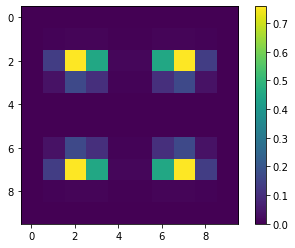

step: 100


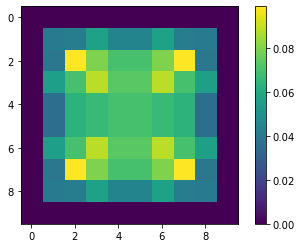

step: 200


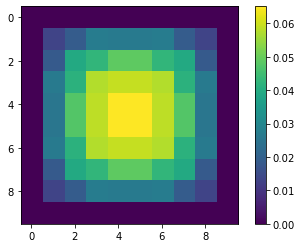

step: 300


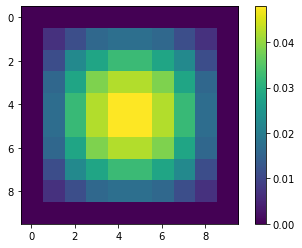

step: 400


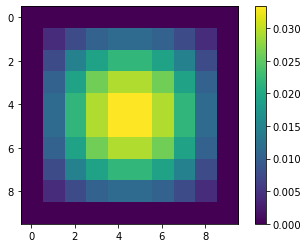

step: 500


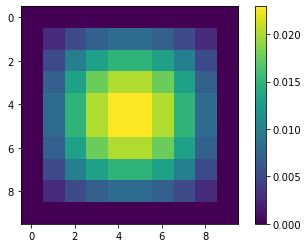

step: 600


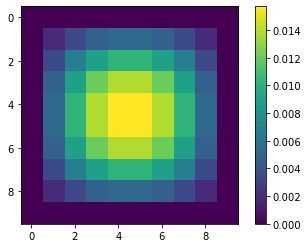

step: 700


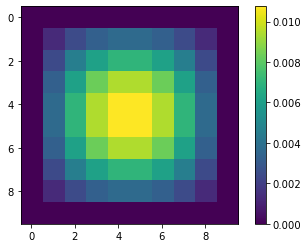

step: 800


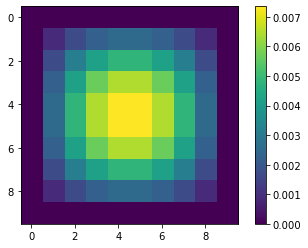

step: 900


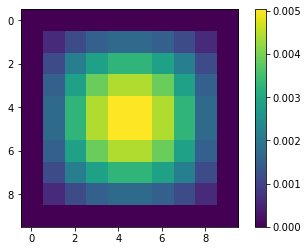

In [9]:
# Write your solution
dx=xTot/nxc
dy=yTot/nyc

steps=1000; totalTime=1.0; plotEverySteps = 100; 
deltaTime=totalTime/steps; diffusivity=20e-2;
r = deltaTime*diffusivity/(dx*dy)
print(r)
T=np.outer(np.sin(2*np.pi*X)**3,np.sin(2*np.pi*Y))**4
for time in np.arange(steps):
    T_Laplacian = LaplacianOp.dot(T.reshape(nxp*nyp))
    T[1:nxp-1,1:nyp-1] += diffusivity*deltaTime * T_Laplacian.reshape(nxp-2,nyp-2) 
    if (time%100)==0: # plots each 100 steps only
        print('step:',time)
        plt.imshow(T);plt.colorbar();plt.show()

## Two-Dimensional Diffusion Equation

By using the same best scaling technique for the one-dimensional diffusion equation, we can now extend it to the two-dimensional case. Here the matrix that multiplies the $\mathbf{T}$ vector will be the Laplacian one that we calculated in. By defining now a function to calculate it, we can find the solution for the implicit problem of a diffusing initially Gussian bell centered around $(0,0.25)$. 

Explicitly we find the 2D equivalent of the above 1D versions as: 

\begin{eqnarray}
\frac{ T^{t+\Delta t} \left( x_i, y_i \right) - T^t \left( x_i, y_i \right) }{\Delta t} = \\ \nonumber
k \frac{T^{t+\Delta t} \left( x_{i+1},y_i \right) -2T^{t+\Delta t} \left( x_i,y_i \right) + T^{t+\Delta t} \left(x_{i-1},y_i \right)}{\Delta x ^2} + \\ \nonumber
k \frac{T^{t+\Delta t} \left( x_i,y_{i+1} \right) -2T^{t+\Delta t} \left( x_i,y_i \right) + T^{t+\Delta t} \left(x_i,y_{i-1} \right)}{\Delta y ^2} 
\label{eq-diff-impl-2D}
\end{eqnarray}

and by parametrizing everything with r, this reduces to:

\begin{equation}
\left( 1+4r \right) T^{t+\Delta t} \left( x_i,y_j \right) -r T^{t+\Delta t} \left( x_i,y_{j+1} \right) -r T^{t+\Delta t} \left( x_i,y_{j-1} \right) -r T^{t+\Delta t} \left( x_{i+1},y_{j} \right) -r T^{t+\Delta t} \left( x_{i+1},y_{j} \right)  = T^t \left( x_i,y_j \right)
\label{eq-diff-impl-2D-2}
\end{equation}

The above discretization of the diffusion matrix can be expressed as a matrix operator. Alternatively we could use the operator by applying twice the cell centered differential operator. The two give very similar, but not identical results. 

The solution with the two approaches, when diffusivity is constant, is very similar. A very fast implementation of the operator that builds the standard 5-points stencil and uses non-optimized dense arrays is the following, where there are periodic BC:

In [10]:
def standardLaplacianOperator(nx,ny,r):
    nxy=nx*ny
    L=np.identity(nxy)*4*r

    # four neighbors
    L+=np.diag(np.ones(nxy-1)*(-r),-1)
    L+=np.diag(np.ones(nxy-1)*(-r),+1)
    L+=np.diag(np.ones(nxy-ny)*(-r),-ny)
    L+=np.diag(np.ones(nxy-ny)*(-r),+ny)

    # Corners
    L[0,0]=2*r
    L[nxy-1,nxy-1]=2*r

    return L


## Exercise 3
Visualize the matrix created by *standardLaplacianOperator()*. It is not like the laplacian operator that we created earlier, first of all because it has ones on the main diagonal, and second because the terms off the diagonal are nicely aligned. Finally, it is squared!

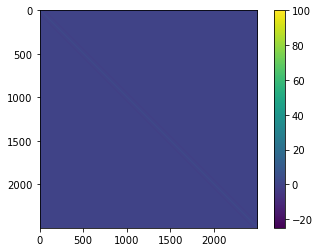

In [11]:
# here do your visualization and experiment (what is the shape of the matrix?) 
# How does it related to the previous laplacians?
nxp = nyp = 50
r = 25
stdLapOp = standardLaplacianOperator(nxp, nyp, r)

plt.imshow(stdLapOp)
#plt.xlim((0,50))
#plt.ylim((50,0))
plt.colorbar()
plt.show()


This Laplacian Operator can be tested on a standard $50 \times 50$ lattice with a high $r=25.0$, which diffuses very quickly down to a value of the order of $10^{-16}$ in only 100 steps using the straightforward inversion approach, without showing any instability:

step: 0


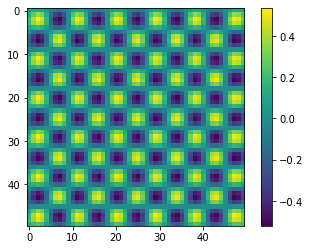

step: 1


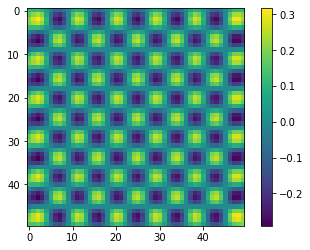

step: 2


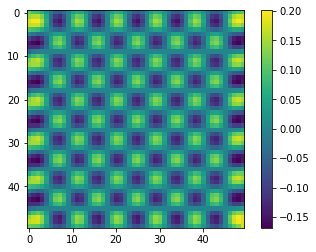

step: 3


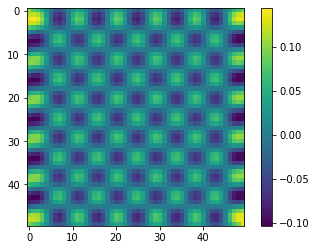

step: 4


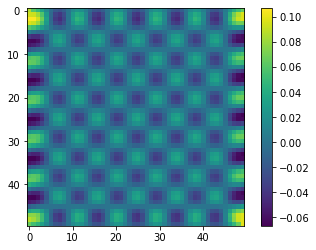

step: 5


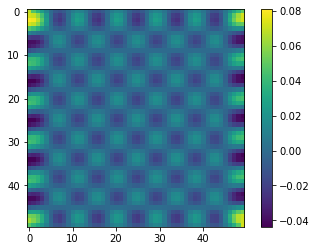

step: 6


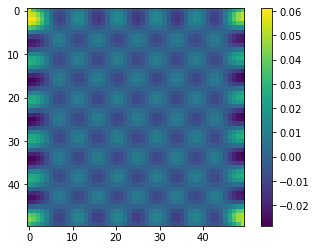

step: 7


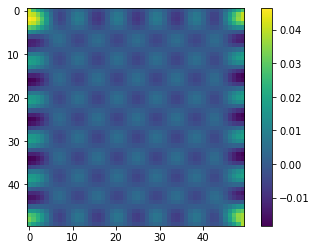

step: 8


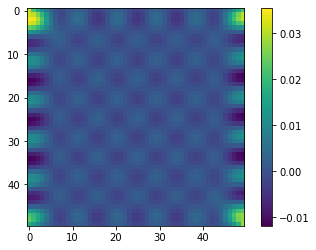

step: 9


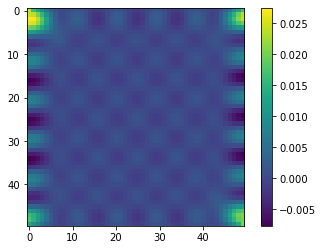

In [12]:
from numpy.linalg import inv as denseInv
import time
nxp = nyp = 50
r = 5
X=np.arange(nxp)*dx+xMin
Y=np.arange(nyp)*dy+yMin
T=np.outer(np.sin(2*np.pi*X),np.sin(2*np.pi*Y))

r=1. 
L=np.identity(nxp*nyp)+standardLaplacianOperator(nxp,nyp,r)
invL = denseInv(L)
for time in np.arange(steps//100):
    T = invL.dot(T.reshape(nxp*nyp)).reshape(nxp,nyp)
    print('step:',time)
    plt.imshow(T);plt.colorbar();plt.show()

While this approach is simple, it is however limited to systems with constant parameters. To analyze for example convection in the Earth's Mantle or in a magma chamber, or the Darcy flow in a very heterogeneous crust we will need a more flexible tool that can handle large parametric variations. 

## Boundary Conditions

Let's see how to build these general sparse matrices by using completely vectorized and sparse Side Operators. The first temptation would be to use the $sparseLaplacianOperator$ function illustrated earlier. However this operator is defined by a rectangular, not squared, matrix, therefore it cannot be inverted. The reason is that this operator projects a $nxp \times nyp$ array into a $(nxp-2) \times (nyp-2)$ array. The missing lines can be added depending on the $Boundary$ $Conditions$. If we assume that the field value are given at the boundary nodes ($Dirichlet$ Boundary Conditions), we have only to add empty lines to the Laplacian operator. A simple routine follows that add the $identity$ matrix (IM) to the Laplacian operator. In this way the values corresponding to empty lines do not change (they are multiplied by IM):

In [13]:
def addBC(operatorWithoutBC,nxp,nyp): # add Boundary Conditions
    nxy=nxp*nyp    
    operatorWithBC=sparse.lil_matrix((nxy,nxy))
    indexes = np.arange(nxy)

    # selects only the interior points
    oldLines = (indexes>=nyp) * (indexes<=nxy-nyp) * (indexes % nyp != 0) * (indexes % nyp != nyp-1) 
    operatorWithBC[oldLines,:]=operatorWithoutBC[:,:]  
    operatorWithBC[~oldLines,~oldLines]=1.0 
    return operatorWithBC

between sparse matrices is slowed down by the use of dense matrices to be performed by NumPy. Because of this weakness, it presently works efficiently only up to a resolution of $100 \times 100$. This weakness might not remain in future implementation of the $scipy.sparse$ library. And the reader is welcome to suggest alternative approaches. For example it is possible to write a routine that directly adds these lines using the Sparse Matrix notation, based on three arrays, one with the x-index, a second with the y-index and a third with the corresponding non-zero matrix value.

We are not ready to run our sparse 2D solver, similarly to the 1D example. By running this example one can observe how the BC are perfectly dealt:

In [14]:
import scipy.sparse.linalg as la

T=np.outer(np.sin(2*np.pi*X),np.sin(2*np.pi*Y))

LaplacianOp=sparseLaplacianOperator(nxp,nyp,dx,dy) #create laplacian operator A
LaplacianOp=addBC(LaplacianOp,nxp,nyp)*r*dx*dx  # add boundary conditions
IA=sparse.eye(nxp*nyp).tocsc()-LaplacianOp  # I-A # create the I-A operator for diffusion

for thisStep in np.arange(steps):
    T = la.spsolve(IA,T.reshape(nxp*nyp)).reshape(nxp,nyp)
    


When increasing the  computational efficiency for the dense inversion and sparse solver in 2D. The problem size at which the solver starts to be more efficient is much greater. This is due to the fact that the matrix $IA$ in 2D is more complex (contains on average 5 terms per row) than in 1D. In 3D obviously this trend is even greater and to reach a solution with this approach is more challenging.

## Biharmonic operator

Besides describing the dynamics of diffusion, Laplacian operators can also be applied to the solution of the momentum equation. In fact there is a formulation that uses a *Stream Function*to express two-dimensional flow, in the case of incompressible flow and homogeneous viscosity. The method simply uses the fact that the Laplacian applied to the Laplacian operator, called $biharmonic$ $operator$ solves the $Stream$ $Function$ equation. Let's see how it works.

The assumption is that there must be a function $\Psi(x,t)$ whose partial derivatives in space are the velocities:
\begin{align*}
	\frac{\partial \Psi}{\partial y} &= v_x \\
	\frac{\partial \Psi}{\partial x} &= -v_y 
\end{align*}
	
This formulation automatically implies that the divergence of the velocity $\frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}= 0 $  is zero, and therefore that the flow is incompressible, regardless to the shape of the function $\Psi$. We can therefore focus on finding the function $\Psi$ that solves the momentum equation only.
		
X and y Stokes (momentum) equations, assuming constant viscosity, simplify into:
\begin{align*}
\eta \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) v_x - \frac{\partial p}{\partial x} = \rho g_x \\
\eta \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) v_y - \frac{\partial p}{\partial y} = \rho g_y 
\end{align*}

By adding cross-deriving them, the first respect to $y$ and the second respect to $x$, the pressure is eliminated and one remains with:

\begin{equation}
\eta \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) \Psi = \frac{\partial \rho}{\partial x} g_y - \frac{\partial \rho}{\partial y} g_x
\end{equation}

where we recognize the Laplacian operator applied twice. We can therefore solve this system by creating a new operator, called biharmonic, composed by the Laplacian of the Laplacian. It is also interesting to notice that by applying only one Laplacian one obtains the so called *vorticity*, that we will analyze more in detail in the last part of the book. The *Stream Function* $\Psi$ allows finally calculating the velocity field. This seemingly twisted approach is in fact very fast and efficient. Let's use the squared *Laplacian* operator to create a solver for the biharmonic equation:

In [15]:
def biharmonicOperator(nxp,nyp,dx,dy):
    return (addBC( sparseLaplacianOperator(nxp,nyp,dx,dy),nxp,nyp)**2 )        

With the operator approach, that was easy and compact. Since we will calculate derivative in the lattice and we may want to project the solution from the cell centers to the mesh, and vice-versa. This can be done with two self-explanatory functions:

In [16]:
def MeshToVolume(nxp,nyp):
    return buildSparseOperatorYaxis(nxp-1,nyp,0.5,0.5).dot( buildSparseOperatorXaxis(nxp,nyp,0.5,0.5) )

In [17]:
def VolumeToMesh(nxp,nyp):
    return buildSparseOperatorXaxis(nxp,nyp,0.5,0.5).transpose().dot( buildSparseOperatorYaxis(nxp-1,nyp,0.5,0.5).transpose() )        

## Exercise 4
Make some experiments with the functions MeshtoVolume and VolumeToMesh, to understand how they work. They project information between finer and coarser meshes. 

In [18]:
# here write your solution





In the second function I have used the $transpose$ to project back from the midpoint to the lattice. This creates a small information diffusion, that is anyway inevitable since the operator projects less informations to a finer array (from $(nxp-1) \times (nyp-1)$ to $nxp \times nyp$.

As an example, let's solve the biharmonic equation for two gravity driven anomalies entrapped in a closed box. This is a common case in geological media.

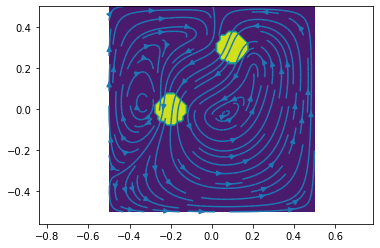

In [19]:
nxp=61; nxc=nxp-1; nxpInt=nxc-1; xTot=1.0; 
nyp=61; nyc=nyp-1; nypInt=nyc-1; yTot=1.0; 
dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0
steps=2; totalTime=2.0; deltaTime=totalTime/steps; 

#allocate arrays
X=np.arange(nxp)*dx+xMin; Y=np.arange(nyp)*dy+yMin
vx = np.zeros((nxp,nyp), float)  # x-velocity solution
vy = np.zeros((nxp,nyp), float)  # y-velocity solution
psi = np.zeros((nxp,nyp), float)  # sreamline function

visc = 1.; gy=-10.; gx=0.

(Dx,Dy)= sparseGradientOperator(nxp,nyp,dx,dy) 

# initial conditions, create two density anomalies
density=np.zeros((nxp,nyp),float) 
cx1=-0.2;cx2=0.1;cy1=0.0;cy2=0.3;radius=0.05; #center and radius
XX=np.outer(X,np.ones(nyp));YY=np.outer(np.ones(nxp),Y);
anomalyIndexes = ((XX-cx1)**2+(YY-cy1)**2<radius**2*2) 
anomalyIndexes+= ((XX-cx2)**2+(YY-cy2)**2<radius**2*2) 
density[anomalyIndexes]=1.0 

# solve for the streamline function
rhs = VolumeToMesh(nxp,nyp).dot( (1/visc*(gy*Dx-gx*Dy)).dot( density.reshape(nxp*nyp) ))
psi = la.spsolve( biharmonicOperator(nxp,nyp,dx,dy) , rhs ) 

# extract the velocities
vx = (VolumeToMesh(nxp,nyp).dot(Dy.dot(psi))).reshape(nxp,nyp)
vy = (VolumeToMesh(nxp,nyp).dot(-Dx.dot(psi))).reshape(nxp,nyp)

plt.contourf(X,Y,density.T.reshape(nxp,nyp))
plt.streamplot(X,Y,vx.T,vy.T)
plt.axis('equal')
plt.show()

Let's summarize the process to create the biharmonic operator using simpler gradient operators:

In [20]:
import scipy.sparse as sparse

# Functional approach to the calculation of the Laplacian
def sparseGradientOperator(nxp,nyp,dx,dy):
    DxOp = buildSparseOperatorXaxis(nxp,nyp-1,-1.0/dx,1.0/dx) 
    DyOp = buildSparseOperatorYaxis(nxp-1,nyp,-1.0/dy,1.0/dy) 
    sideXOp=buildSparseOperatorYaxis(nxp,nyp, 0.5, 0.5) 
    sideYOp=buildSparseOperatorXaxis(nxp,nyp, 0.5, 0.5) 
    return(DxOp.dot(sideXOp),DyOp.dot(sideYOp))

def sparseLaplacianOperator(nxp,nyp,dx,dy): 
    (cellDxOp,cellDyOp)=sparseGradientOperator(nxp,nyp,dx,dy) 
    (cellDxOpSmall,cellDyOpSmall) = sparseGradientOperator(nxp-1,nyp-1,dx,dy) 
    return(cellDxOpSmall.dot(cellDxOp)+cellDyOpSmall.dot(cellDyOp))

def addBC(operatorWithoutBC,nxp,nyp): # add Boundary Conditions nxy=nxp*nyp
    nxy=nxp*nyp
    operatorWithBC=sparse.lil_matrix((nxy,nxy))
    indexes = np.arange(nxy)
  # selects only the interior points
    oldLines = (indexes>=nyp) * (indexes<=nxy-nyp) * (indexes % nyp != 0) * (indexes % nyp != nyp-1) 
    operatorWithBC[oldLines,:]=operatorWithoutBC[:,:] 
    operatorWithBC[~oldLines,~oldLines]=1.0
    return operatorWithBC

def biharmonicOperator(nxp,nyp,dx,dy):
    return (addBC( sparseLaplacianOperator(nxp,nyp,dx,dy),nxp,nyp)**2 )

## Exercise 5
Do several experiments to understand how all this machinery works. For example:

1) Create and place other "circular" anomalies and observe how they link. 

2) Create a different box. Larger, or higher, and find the solution there for more particles, randomly placed

3) Be creative. Make your own experiment. This is the first time that you have a full solver of a stokes equation and have the possibility to understand how it works.

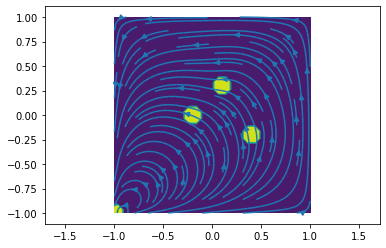

In [21]:
# here write your solutions
nxp=61; nxc=nxp-1; nxpInt=nxc-1; xTot=2.0; 
nyp=61; nyc=nyp-1; nypInt=nyc-1; yTot=2.0; 
dx=xTot/nxc; xMin=-xTot/2.0; xMax=xTot/2.0
dy=yTot/nyc; yMin=-yTot/2.0; yMax=yTot/2.0
steps=2; totalTime=2.0; deltaTime=totalTime/steps; 

#allocate arrays
X=np.arange(nxp)*dx+xMin; Y=np.arange(nyp)*dy+yMin
vx = np.zeros((nxp,nyp), float)  # x-velocity solution
vy = np.zeros((nxp,nyp), float)  # y-velocity solution
psi = np.zeros((nxp,nyp), float)  # sreamline function



visc = 1.; gy=-10.; gx=0.

(Dx,Dy)= sparseGradientOperator(nxp,nyp,dx,dy) 

# initial conditions, create two density anomalies
density=np.zeros((nxp,nyp),float) 
cx1=-0.2; cy1=0.0;
cx2=0.1; cy2=0.3;
cx3 = 0.4; cy3=-0.2; 
cx4 = -1.0; cy4 = -1.0;
radius=0.06; #center and radius

XX=np.outer(X,np.ones(nyp));YY=np.outer(np.ones(nxp),Y);
'''
particleCount = 2
cx = np.random.rand(particleCount)
cy = np.random.rand(particleCount)
anomalyIndexes = 0
for i in range(particleCount):
    anomalyIndexes += ((XX-cx[i])**2+(YY-cy[i])**2<radius**2*2)
    density[anomalyIndexes]=1.0
'''
anomalyIndexes = ((XX-cx1)**2+(YY-cy1)**2<radius**2*2) 
anomalyIndexes+= ((XX-cx2)**2+(YY-cy2)**2<radius**2*2) 
anomalyIndexes+= ((XX-cx3)**2+(YY-cy3)**2<radius**2*2)
anomalyIndexes+= ((XX-cx4)**2+(YY-cy4)**2<radius**2*2)
density[anomalyIndexes]=1.0

# solve for the streamline function
rhs = VolumeToMesh(nxp,nyp).dot( (1/visc*(gy*Dx-gx*Dy)).dot( density.reshape(nxp*nyp) ))
psi = la.spsolve( biharmonicOperator(nxp,nyp,dx,dy) , rhs ) 

# extract the velocities
vx = (VolumeToMesh(nxp,nyp).dot(Dy.dot(psi))).reshape(nxp,nyp)
vy = (VolumeToMesh(nxp,nyp).dot(-Dx.dot(psi))).reshape(nxp,nyp)

plt.contourf(X,Y,density.T.reshape(nxp,nyp))
plt.streamplot(X,Y,vx.T,vy.T)
plt.axis('equal')
plt.show()


    
    





In [22]:
print(cx, cy)

NameError: name 'cx' is not defined

In [ ]:
print(density)